# Market Dynamics of Tech Stocks: An Exploratory Study (AAPL, MSFT, GOOGL, ^GSPC)

**Project Aim**

To conduct a comprehensive exploratory data analysis (EDA) of historical closing price data for selected technology stocks (AAPL, MSFT, GOOGL) and the S&P 500 market index (^GSPC) spanning the period from 2014 to 2024. The analysis aims to identify, characterize, and draw preliminary conclusions regarding:
- Individual Asset Dynamics: The statistical properties, price trends, return distributions, and volatility characteristics (including clustering and peak volatility periods) of each asset.
- Cross-Asset Relationships: The interdependencies, correlations, and market beta of the selected stocks relative to the S&P 500 index, along with a comparative assessment of their risk-return profiles.
- Behavior during Market Stress: The performance, volatility, maximum drawdowns, and correlation shifts of the assets specifically during the significant market stress event of H1 2020 (COVID-19 pandemic).


**Tasks**

1. Data preparation and preliminary data review

   1.1. Choose tickers and time interval for analysis
   
   1.2. Donwload data from Yahoo Finance and save to .csv file

   1.3. Read data from .csv file

   1.4. Process dataframe

   Check for missing values. Retrieve close prices to a new dataframe. Calculate daily returns.
   
2. Individual asset analysis

    2.1. Price and Return Dynamics

   Plot close prices. Plot daily returns and their 20-day and 60-day moving average.

    2.2. Statistical Properties of Daily Returns

   Calculate descriptive statictics (mean, std, min, max, quartiles), min and max returns and their dates, skewness, and kurtosis. Plot Daily Returns, their histograms and kernel density estimation (KDE), boxplots.

    2.3. Volatility analysis

   Plot annualized rolling volatility. Find max values of it and correesponding dates. Check for vloatility clustering.

3. Cross-Asset Analysis and Correlations

    3.1. Risk-Return Profile Comparison

    Calculate average returns and volatilities, make a scatter plot of risk-return Profiles.

    3.2. Correlation Analysis

    Calculate and visualize correlation matrix.

    3.3. Beta Analysis

    Make scatter plots of returns vs S&P 500. Calculate and visualize betas.

4. In-depth Analysis of the Market Stress Period (COVID-19, H1 2020)

    4.1 Data preparation

   Choose period for analysis and prepare the data.

    4.2. Return and Volatility anlysis during stress period

   Plot returns and volatilities during stress period.

    4.3. Analysis of maximum drawdowns during stress period

   Calculate and visualize maximum drawdowns during stress period.

   4.4. Analysis of correlations during stress period

   Calculate and visualize assets correlations during stress period.

5. Conclusion

    Summarize key findings from the analysis and draw overall conclusions based on the project aim and results.

In [1]:
# --- Imports ---
import os

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from scipy import stats

## 1. Data preparation

In [2]:
# --- Configuration ---
tickers_list = ["AAPL", "MSFT", "GOOGL", "^GSPC"]
start_date = "2014-01-01"
end_date = "2024-12-31"
fin_data_filename = "financial_data.csv"

In [3]:
# --- Download Data ---
# Ignore this block if you already have financial_data.csv with the data
# If not, run this block for donwnloading the data to financial_data.csv
"""
print(f"Downloading data for: {', '.join(tickers_list)}")
print(f"Period: {start_date} to {end_date}")

try:
    all_data = yf.download(tickers_list, start=start_date, end=end_date)

    if not all_data.empty:
        print("\nData downloaded successfully.")

        # Check columns structure
        print("\nStructure of downloaded data columns:")
        print(all_data.columns)

        # --- Save Data to CSV ---
        try:
            all_data.to_csv(fin_data_filename)
            print(f"\nAll downloaded data (including OHLCV) successfully saved to: {fin_data_filename}")
        except Exception as e:
            print(f"\nError saving data to {fin_data_filename}: {e}")
            print("Data was downloaded but not saved.")

    else:
        print("\nDownloaded data (all_data) is empty. Please check tickers and date range. Data not saved.")

except Exception as e:
    print(f"\nAn error occurred during download: {e}")
    print("Data not saved.")
"""
pass

In [4]:
# --- Load Data from CSV ---
if os.path.exists(fin_data_filename):
    print(f"Loading data from {fin_data_filename}...")
    try:
        all_data = pd.read_csv(fin_data_filename, header=[0, 1], index_col=0, parse_dates=True)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error loading data from {fin_data_filename}: {e}")
        all_data = pd.DataFrame() # Initialize empty dataframe if loading fails
else:
    print(f"File {fin_data_filename} not found. Please run the download block first.")
    all_data = pd.DataFrame() # Initialize empty dataframe if the file does not exist

# --- Brief Data Description ---
if not all_data.empty:
    # Uncomment for detailed data inspection
    '''
    print("\n--- Data Inspection ---")
    print("\nData head:")
    print(all_data.head())
    print("\nData columns:")
    print(all_data.columns)

    print("\n--- Data Info ---")
    all_data.info()
    '''

    actual_start_date = all_data.index.min().strftime('%Y-%m-%d')
    actual_end_date = all_data.index.max().strftime('%Y-%m-%d')
    num_observations = len(all_data)
    num_tickers_data = len(all_data.columns.levels[1]) # Number of unique tickers in the second level of the multiindex columns

    print("\n--- Brief Data Description ---")
    print(f"The dataset contains financial data for {num_tickers_data} assets ({', '.join(all_data.columns.levels[1].tolist())}).")
    print(f"Actual data period in the loaded file: {actual_start_date} to {actual_end_date}.")
    print(f"Total number of trading days (observations): {num_observations}.")
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")

Loading data from financial_data.csv...
Data loaded successfully.

--- Brief Data Description ---
The dataset contains financial data for 4 assets (AAPL, GOOGL, MSFT, ^GSPC).
Actual data period in the loaded file: 2014-01-02 to 2024-12-30.
Total number of trading days (observations): 2767.


In [5]:
# Check for missing data
if not all_data.empty:
    print("--- Missing Values Check ---")
    missing_values = all_data.isnull().sum()
    # Filter columns with no missing values
    missing_values_summary = missing_values[missing_values > 0]
    if not missing_values_summary.empty:
        print("Columns with missing values:")
        print(missing_values_summary)
    else:
        print("No missing values found in the dataset.")
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")

--- Missing Values Check ---
No missing values found in the dataset.


In [6]:
# Retrieve 'Close' values
if not all_data.empty:
    if 'Close' in all_data.columns.levels[0]:
        close_data = all_data['Close'].copy()
        print("\n'Close' prices data selected for analysis. Head:")
        print(close_data.head())
    else:
        print("\nError: 'Close' data not found in the first level of columns. Please check data structure.")
        close_data = pd.DataFrame()
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")
    close_data = pd.DataFrame()


'Close' prices data selected for analysis. Head:
Ticker           AAPL      GOOGL       MSFT        ^GSPC
Date                                                    
2014-01-02  17.192829  27.723312  30.939615  1831.979980
2014-01-03  16.815168  27.521074  30.731455  1831.369995
2014-01-06  16.906870  27.827919  30.082041  1826.770020
2014-01-07  16.785944  28.364391  30.315155  1837.880005
2014-01-08  16.892250  28.423416  29.773956  1837.489990


In [7]:
# --- Calculating Daily Returns ---
if not close_data.empty:
    print("\n--- Calculating Daily Returns ---")
    daily_returns = close_data.pct_change()
    daily_returns = daily_returns.dropna()
    print("\nDaily Returns head:")
    print(daily_returns.head())
else:
    if not all_data.empty:
        print("'Close' data is empty or not found, cannot calculate returns.")
    daily_returns = pd.DataFrame()


--- Calculating Daily Returns ---

Daily Returns head:
Ticker          AAPL     GOOGL      MSFT     ^GSPC
Date                                              
2014-01-03 -0.021966 -0.007295 -0.006728 -0.000333
2014-01-06  0.005453  0.011149 -0.021132 -0.002512
2014-01-07 -0.007152  0.019278  0.007749  0.006082
2014-01-08  0.006333  0.002081 -0.017852 -0.000212
2014-01-09 -0.012770 -0.009630 -0.006431  0.000348


## 2. Individual Asset Analysis

### 2.1. Price and Return Dynamics

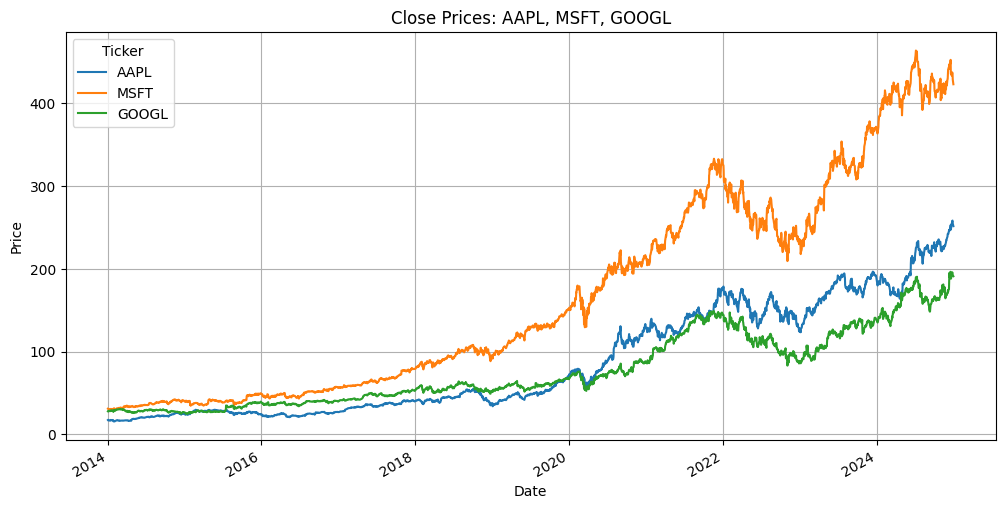

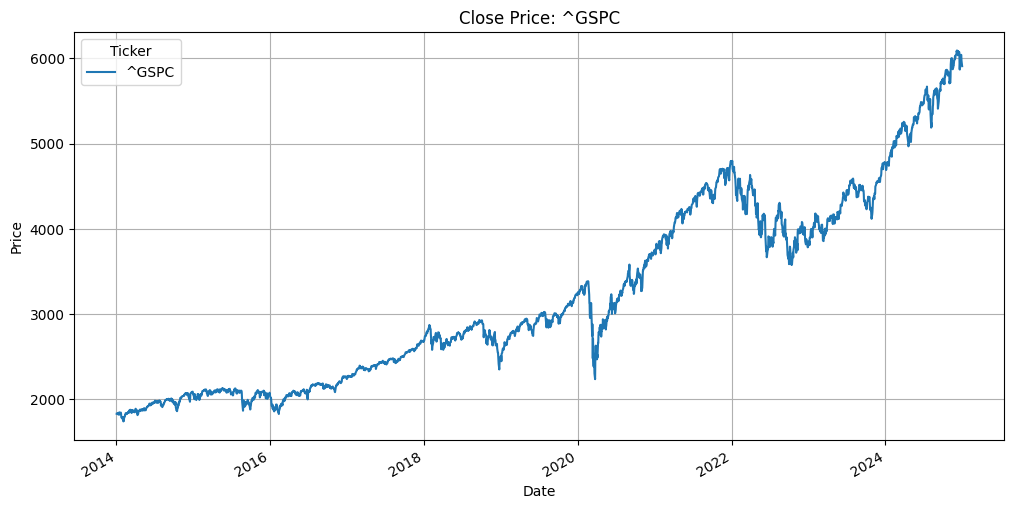

In [36]:
# Plot individual tickers and index ticker (AAPL, MSFT, GOOGL, ^GSPC) in 4 separate windows or in a single window
'''
if not close_data.empty:
    close_data.plot(figsize=(12, 6), title="Close Prices", subplots=False) # subplots=True for separate subplots
    plt.ylabel("Price")
    plt.legend(title='Ticker')
    plt.show()
'''

# Plot individual tickers (AAPL, MSFT, GOOGL) and index ticker (^GSPC) in 2 separate windows
if not close_data.empty:

    individual_tickers = tickers_list[:3] # AAPL, MSFT, GOOGL
    index_ticker = tickers_list[3]  # ^GSPC - S&P 500

    # --- AAPL, MSFT, GOOGL ---
    if all(ticker in close_data.columns for ticker in individual_tickers):
        fig1, ax1 = plt.subplots(figsize=(12, 6))

        for ticker in individual_tickers:
            close_data[ticker].plot(ax=ax1, label=ticker)

        ax1.set_title(f"Close Prices: {', '.join(individual_tickers)}")
        ax1.set_ylabel("Price")
        ax1.legend(title='Ticker')
        ax1.grid(True)

    else:
        print(f"Warning: Not all individual tickers ({', '.join(individual_tickers)}) found in close_data.")

    # --- ^GSPC ---
    if index_ticker in close_data.columns:
        fig2, ax2 = plt.subplots(figsize=(12, 6))

        close_data[index_ticker].plot(ax=ax2, label=index_ticker)

        ax2.set_title(f"Close Price: {index_ticker}")
        ax2.set_ylabel("Price")
        ax2.legend(title='Ticker')
        ax2.grid(True)
        # plt.ylim(bottom=0)

    else:
        print(f"Warning: Index ticker ({index_ticker}) not found in close_data.")
    
    plt.show()

else:
    print("'close_data' is empty. Skipping plotting.")

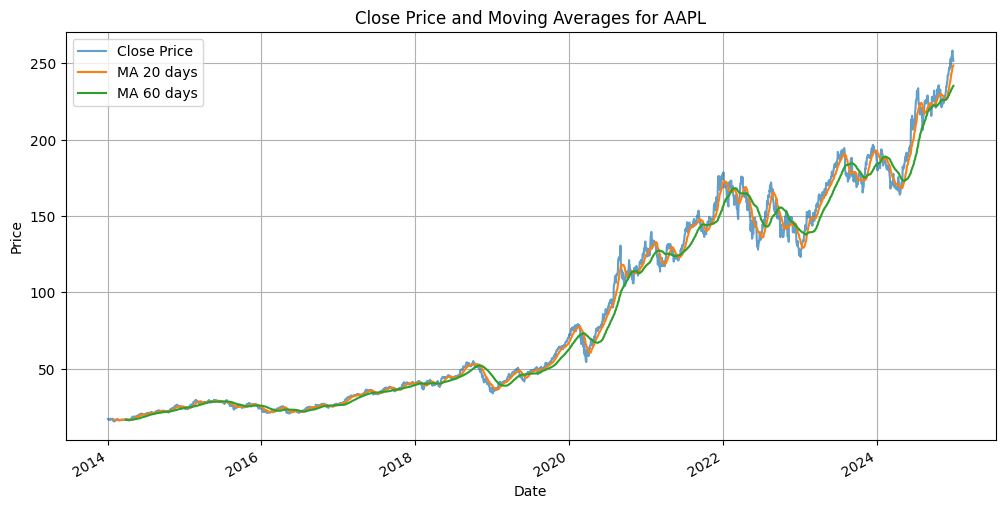

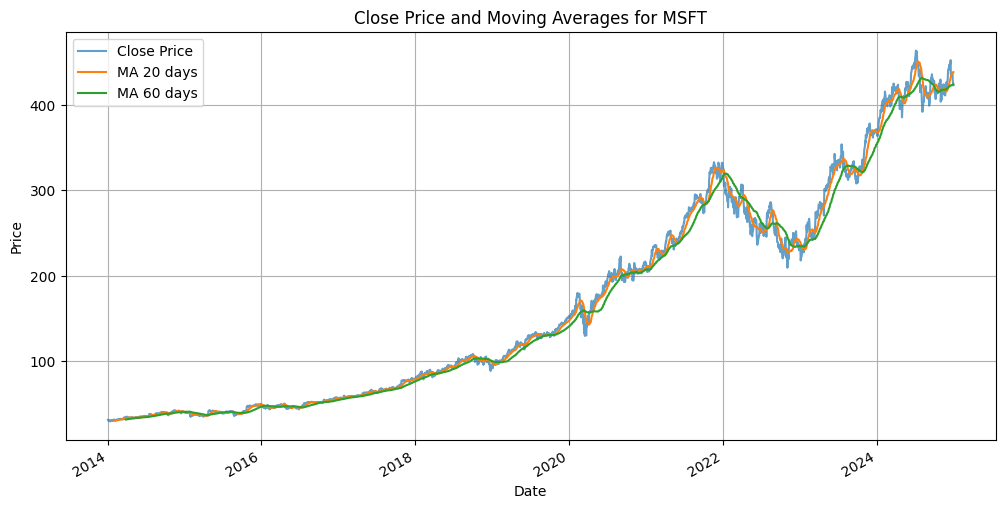

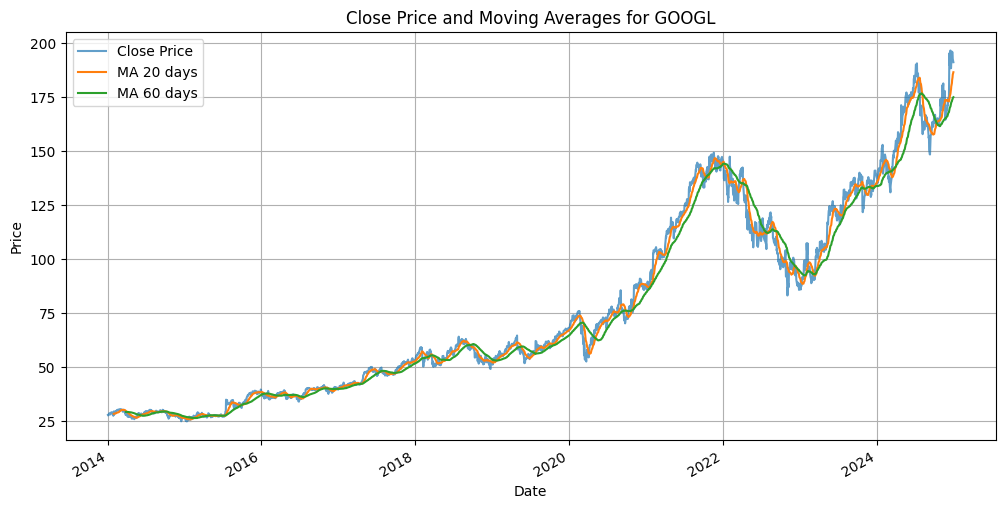

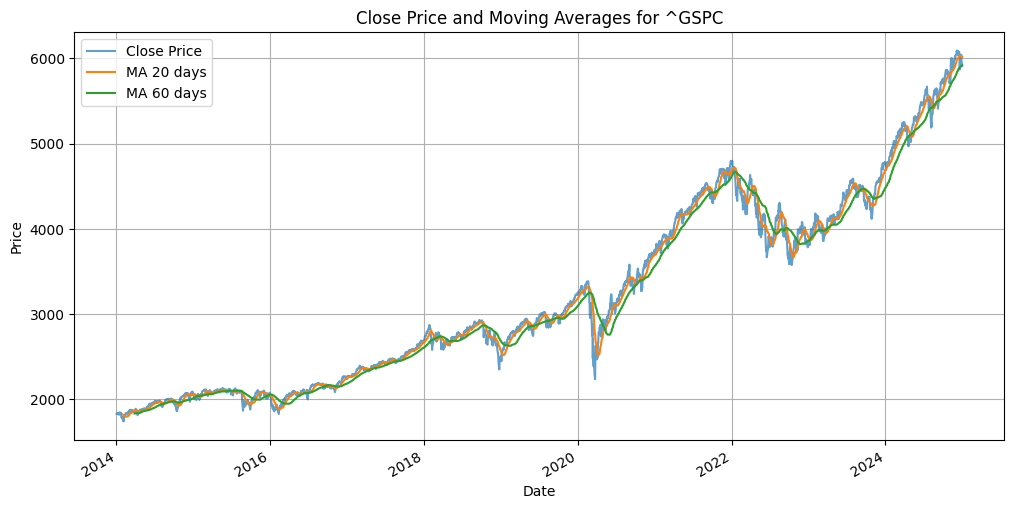

In [28]:
if not close_data.empty:
    short_window = 20  # 20-day moving average (~ month)
    long_window = 60   # 60-day moving average (~ quartal)

    for ticker in tickers_list:
        if ticker in close_data.columns:
            plt.figure(figsize=(12, 6))
            close_data[ticker].plot(label='Close Price', alpha=0.7)
            close_data[ticker].rolling(window=short_window).mean().plot(label=f'MA {short_window} days')
            close_data[ticker].rolling(window=long_window).mean().plot(label=f'MA {long_window} days')
            plt.title(f"Close Price and Moving Averages for {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True)
            plt.show()

**Observation.** Prices of Apple, Microsoft, and Google demonstrated confident growth. There were several periods of significant drawdowns, two of the most sever of which happend in the first half of 2020 and during 2022. The first is due to COVID-19 strike and the second is connected with economics and politics aftermaths fo COVID as well as geopolitical situation.

**Observation.** Among 3 assets Microsoft showed the most rapid growth.

### 2.2. Statistical Properties of Returns

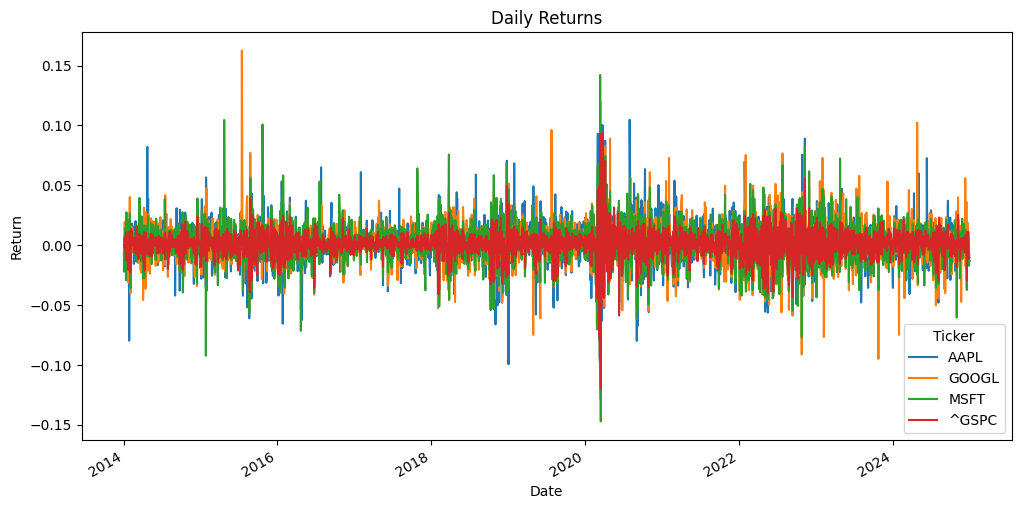

In [10]:
if 'daily_returns' in locals() and not daily_returns.empty:
    daily_returns.plot(figsize=(12, 6), title="Daily Returns", subplots=False) # subplots=True for separate subplots
    plt.ylabel("Return")
    plt.show()

**Observation.** There are notable prices volatilities in the first half of 2020.

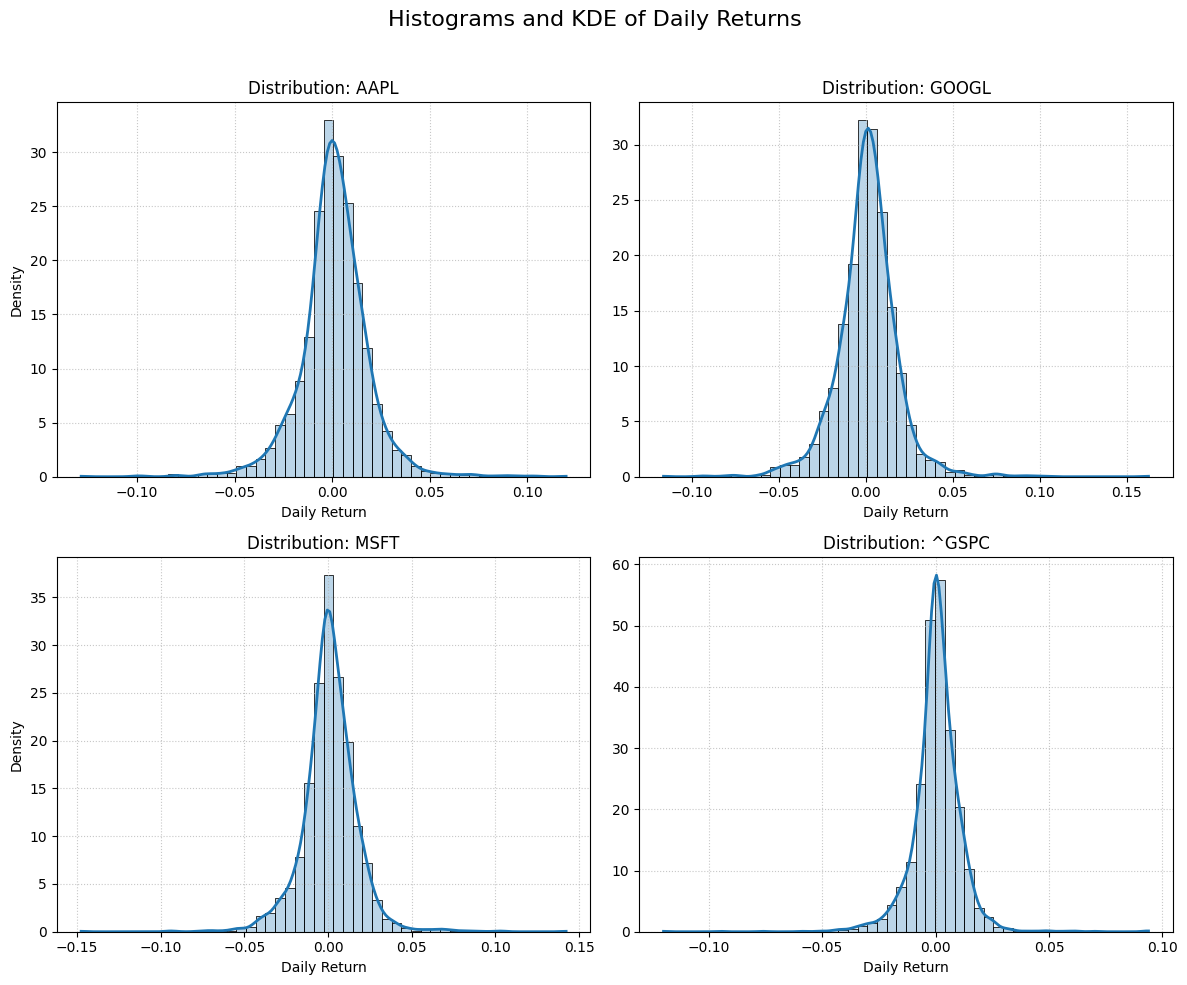

In [11]:
if 'daily_returns' in locals() and not daily_returns.empty:

    num_tickers = len(daily_returns.columns)
    if num_tickers <= 0:
        print("No columns in daily_returns to plot.")
    else:
        nrows = 2
        ncols = 2
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10), sharex=False, sharey=False)
        axes_flat = axes.flatten()

        # Choose the type of staticstics for plotting histogram - density or frequency
        stat_type = "density"
        # stat_type = "frequency"

        for i, ticker in enumerate(daily_returns.columns):
            current_ax = axes_flat[i]

            sns.histplot(daily_returns[ticker], kde=True, bins=50, ax=current_ax, stat=stat_type, alpha=0.3, line_kws={'linewidth': 2})

            current_ax.set_title(f"Distribution: {ticker}")
            current_ax.set_xlabel("Daily Return")
                
            # Y-axis labels
            if i % ncols == 0: 
                current_ax.set_ylabel(stat_type.capitalize())
            else:
                current_ax.set_ylabel("")

            current_ax.grid(True, linestyle=':', alpha=0.7)

        
        fig.suptitle("Histograms and KDE of Daily Returns", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

else:
    print("DataFrame 'daily_returns' is empty or not defined. Skipping histograms.")

In [12]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Descriptive Statistics for Daily Returns ---")
    desc_stats = daily_returns.describe()
    print(desc_stats)

    print("\nSkewness:")
    print(daily_returns.skew())
    print("\nKurtosis:")
    print(daily_returns.kurt())

    print("\n--- Extreme Daily Returns and Their Dates ---")
    extreme_values_info = []

    # Min and max returns and their dates
    for ticker in daily_returns.columns:
        min_return = daily_returns[ticker].min()
        date_min_return = daily_returns[ticker].idxmin()

        max_return = daily_returns[ticker].max()
        date_max_return = daily_returns[ticker].idxmax()

        extreme_values_info.append({
            "Ticker": ticker,
            "Min Return": min_return,
            "Date of Min Return": date_min_return.strftime('%Y-%m-%d'),
            "Max Return": max_return,
            "Date of Max Return": date_max_return.strftime('%Y-%m-%d')
        })

    extreme_values_df = pd.DataFrame(extreme_values_info)
    extreme_values_df = extreme_values_df.set_index("Ticker")

    print(extreme_values_df)

else:
    print("DataFrame 'daily_returns' is empty or not defined. Skipping descriptive statistics.")


--- Descriptive Statistics for Daily Returns ---
Ticker         AAPL        GOOGL         MSFT        ^GSPC
count   2766.000000  2766.000000  2766.000000  2766.000000
mean       0.001125     0.000852     0.001085     0.000483
std        0.017582     0.017573     0.016695     0.010922
min       -0.128647    -0.116341    -0.147390    -0.119841
25%       -0.007012    -0.007571    -0.006717    -0.003737
50%        0.001001     0.001142     0.000908     0.000653
75%        0.010116     0.009470     0.009664     0.005662
max        0.119808     0.162584     0.142169     0.093828

Skewness:
Ticker
AAPL    -0.011635
GOOGL    0.230104
MSFT     0.075650
^GSPC   -0.532558
dtype: float64

Kurtosis:
Ticker
AAPL      5.567478
GOOGL     6.688485
MSFT      7.904332
^GSPC    14.952258
dtype: float64

--- Extreme Daily Returns and Their Dates ---
        Min Return Date of Min Return  Max Return Date of Max Return
Ticker                                                              
AAPL     -0.128647  

**Observation.** Each asset yielded income (mean > 0) during the considered 11-year period.

**Observation.** Each asset's daily volatility is between 1% and 2%.

**Observation.** The highest daily price jump constitued to 16.26% (GOOGL) and the maximum drawdown was 14.74% (MSFT).

**Observation.** GOOGL and MSFT exhibited positive skewness meaning these assets made profits more frequently than losses. The behavior of AAPL and ^GSPC prices is opposite in this sense.

**Observation.** Each asset demontrates large positive kurtosis (> 5) indicating the prices destributions had heavier tails compared to normal distribution. This non-gaussianity of market prices manifested itself drammatically for the index ^GSPC.


--- Boxplots for Daily Returns ---


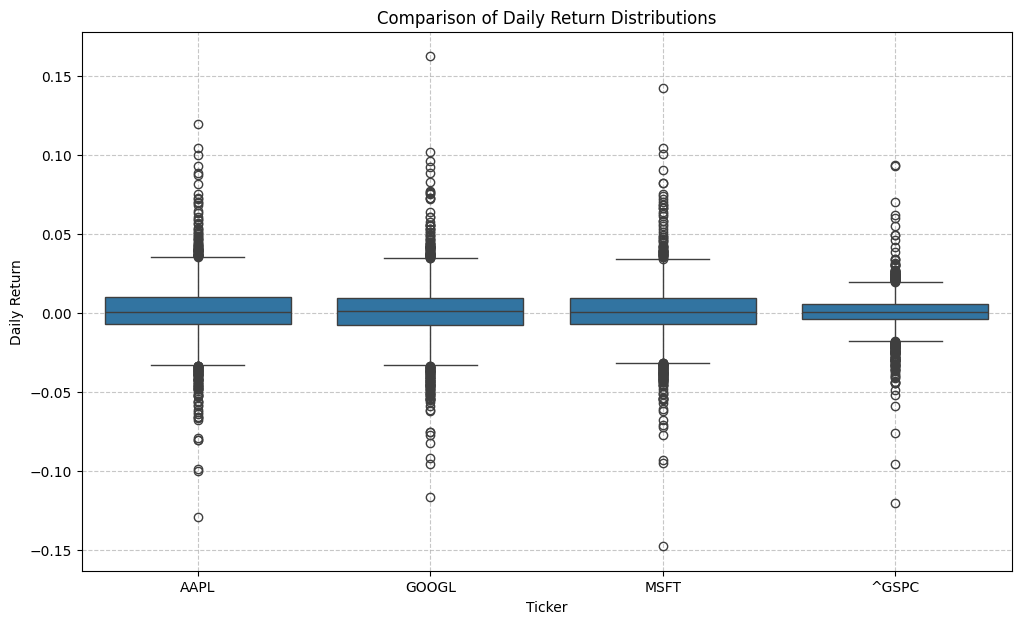

In [13]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Boxplots for Daily Returns ---")
    melted_returns = daily_returns.melt(var_name='Ticker', value_name='Return')

    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Ticker', y='Return', data=melted_returns)
    plt.title("Comparison of Daily Return Distributions")
    plt.xlabel("Ticker")
    plt.ylabel("Daily Return")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

**Observation.** Each asset has a lot of points behind whiskers signalling of many days of exceptional daily returns.

**Observation.** Index prices (^GSPC) are less volatile compared to those of individual assets that is indicated by the interquartile ranges.

### 2.3. Volatility analysis

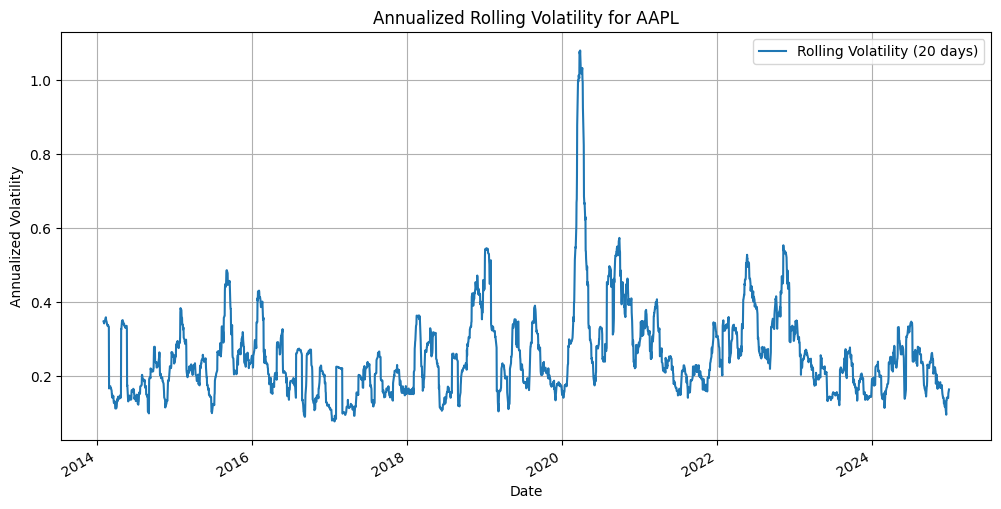

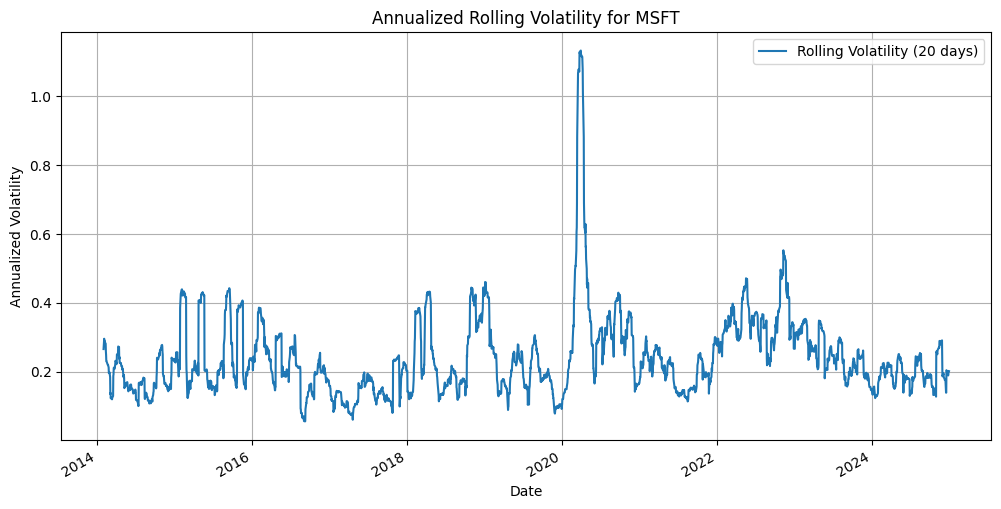

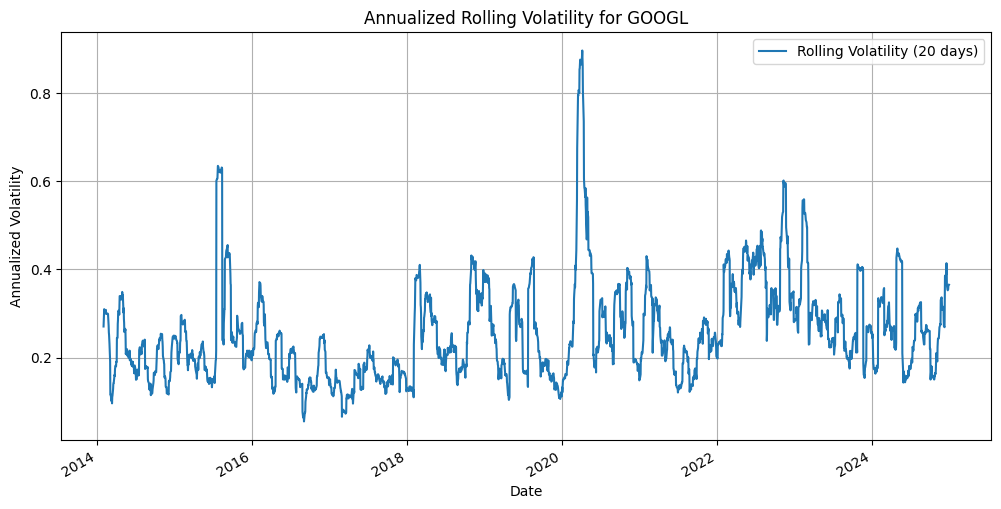

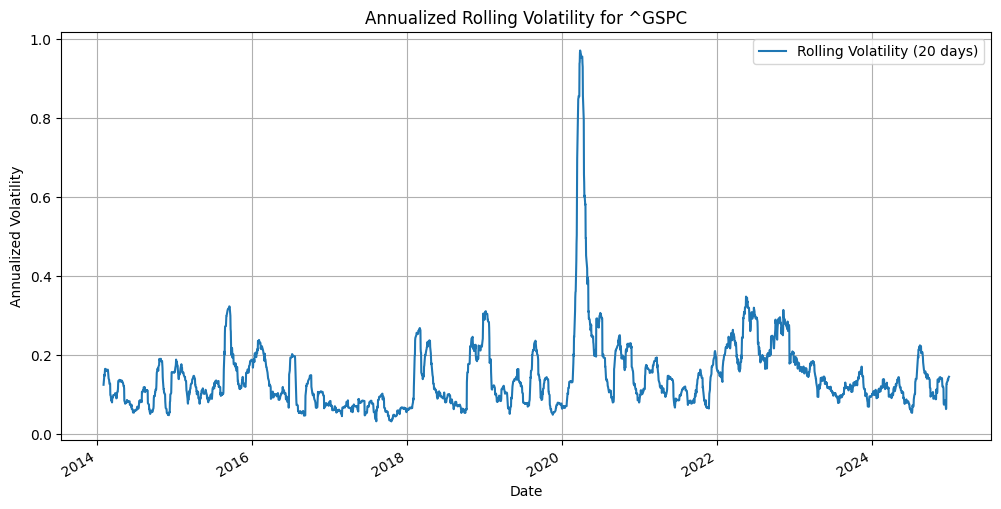


--- Peak Annualized Rolling Volatility ---
        Max Volatility Date of Max Volatility
Ticker                                       
AAPL          1.079532             2020-03-27
MSFT          1.131446             2020-03-30
GOOGL         0.895755             2020-04-06
^GSPC         0.971241             2020-03-27


In [32]:
if 'daily_returns' in locals() and not daily_returns.empty:

    vol_window = 20
    max_rolling_volatility_info = []

    for ticker in tickers_list:
        if ticker in daily_returns.columns:
            rolling_std = daily_returns[ticker].rolling(window=vol_window).std() * (252**0.5) # Annualized volatility

            if not rolling_std.dropna().empty:
                max_vol = rolling_std.dropna().max()
                date_max_vol = rolling_std.dropna().idxmax()
                
                max_rolling_volatility_info.append({
                    "Ticker": ticker,
                    "Max Volatility": max_vol,
                    "Date of Max Volatility": date_max_vol.strftime('%Y-%m-%d')
                })
            else:
                max_rolling_volatility_info.append({
                    "Ticker": ticker,
                    "Max Volatility": np.nan,
                    "Date of Max Volatility": "N/A"
                })

            plt.figure(figsize=(12, 6))
            rolling_std.plot(label=f'Rolling Volatility ({vol_window} days)')
            plt.title(f"Annualized Rolling Volatility for {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Annualized Volatility")
            plt.legend()
            plt.grid(True)
            plt.show()

    if max_rolling_volatility_info:
        max_rolling_vol_df = pd.DataFrame(max_rolling_volatility_info)
        max_rolling_vol_df = max_rolling_vol_df.set_index("Ticker")
        print("\n--- Peak Annualized Rolling Volatility ---")
        print(max_rolling_vol_df)

else:
    print("DataFrame 'daily_returns' is empty or not defined. Skipping rolling volatility analysis.")

**Observation.** Each asset exhibited the highest volitility values during March - April 2020.


--- Autocorrelation of Squared Returns (Volatility Clustering Check) ---


<Figure size 1200x600 with 0 Axes>

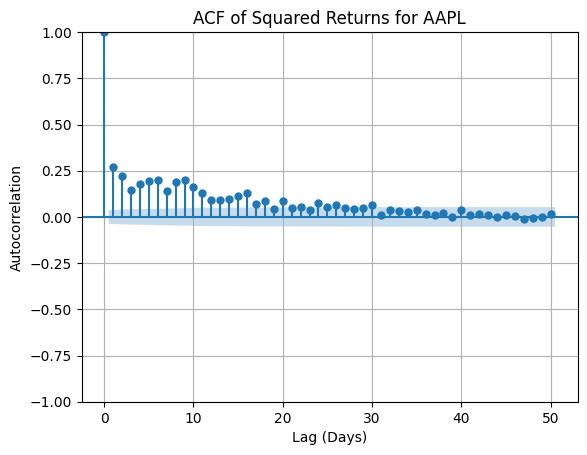

<Figure size 1200x600 with 0 Axes>

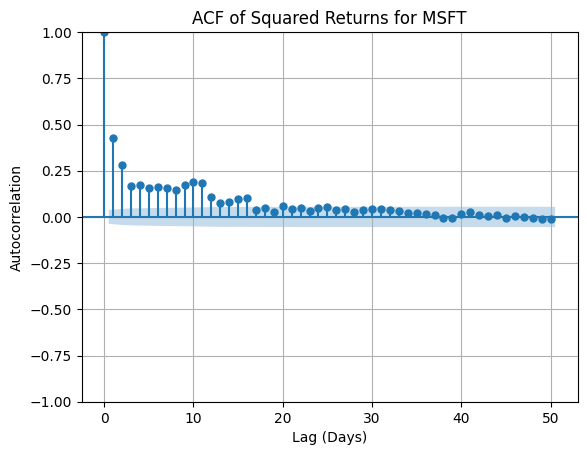

<Figure size 1200x600 with 0 Axes>

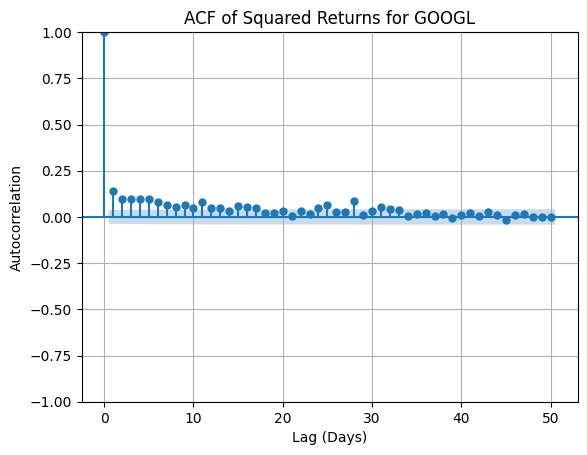

<Figure size 1200x600 with 0 Axes>

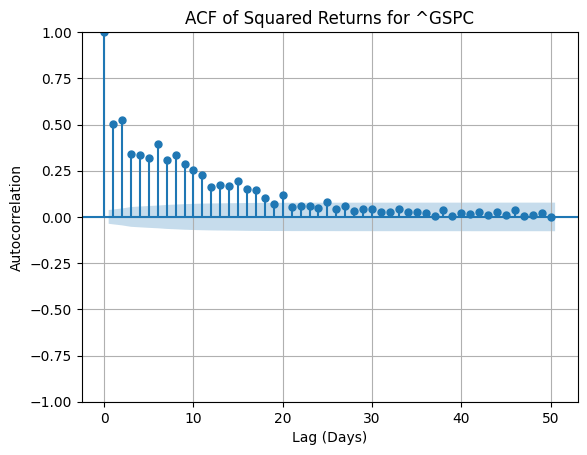

In [33]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Autocorrelation of Squared Returns (Volatility Clustering Check) ---")
    for ticker in tickers_list:
        if ticker in daily_returns.columns:
            squared_returns = daily_returns[ticker]**2
            plt.figure(figsize=(12, 6))
            plot_acf(squared_returns, lags=50, alpha = 0.05, title=f'ACF of Squared Returns for {ticker}') # try different alphas
            plt.xlabel("Lag (Days)")
            plt.ylabel("Autocorrelation")
            plt.grid(True)
            plt.show()

**Observation.** Each asset demonetrated volatility clustering when periods of high volitility are followed by periods of high volatility, and periods of low volitility are followed by periods of low volatility.

**Observation.** With 95% confidence: AAPL and ^GSPC exhibit 18-day volatility clustering periods. For MSFT the clustring period is 16 days. The clustering period for GOOGL is between 13 and 17 days.

# 3. Cross-Asset Analysis and Correlations

### 3.1. Risk-Return Profile Comparison


--- Risk-Return Profile Analysis ---

Risk-Return Profile (Annualized):
        Annualized Return  Annualized Volatility
Ticker                                          
AAPL             0.283531               0.279101
GOOGL            0.214716               0.278957
MSFT             0.273520               0.265028
^GSPC            0.121776               0.173382


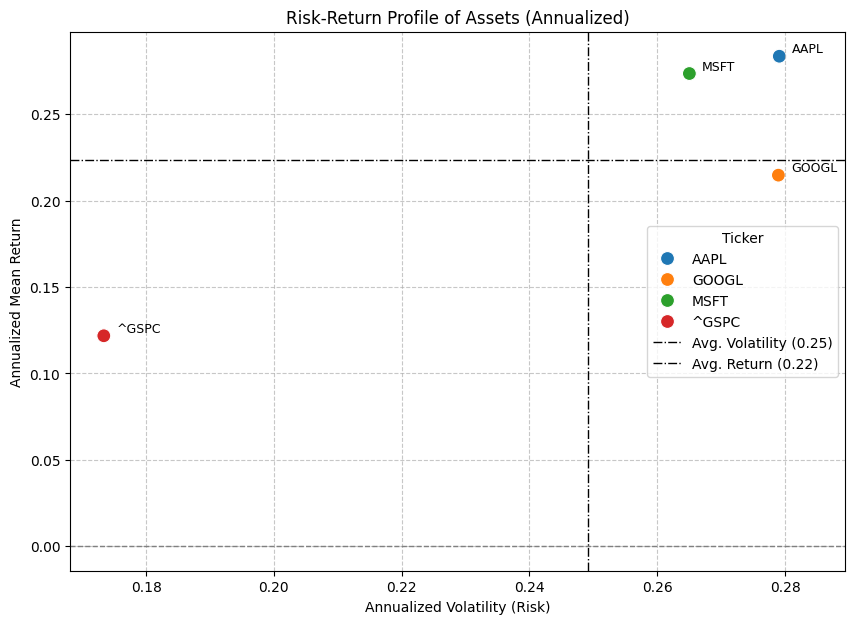

In [35]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Risk-Return Profile Analysis ---")

    mean_daily_returns = daily_returns.mean()
    std_daily_returns = daily_returns.std()

    # Annualized return and volatility
    annualized_returns = mean_daily_returns * 252
    annualized_volatility = std_daily_returns * np.sqrt(252)

    risk_return_profile = pd.DataFrame({
        'Annualized Return': annualized_returns,
        'Annualized Volatility': annualized_volatility
    })

    print("\nRisk-Return Profile (Annualized):")
    print(risk_return_profile)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Annualized Volatility', y='Annualized Return', data=risk_return_profile, s=100, hue=risk_return_profile.index, legend='full') # s=100 размер точек

    # Points labels
    for i in range(risk_return_profile.shape[0]):
        ticker_name = risk_return_profile.index[i]
        volatility_value = risk_return_profile['Annualized Volatility'].iloc[i]
        return_value = risk_return_profile['Annualized Return'].iloc[i]
        
        plt.text(x=volatility_value+0.002,
                 y=return_value +0.002,
                 s=ticker_name,
                 fontdict=dict(color='black',size=9))

    # Shift right limit of the plot for the labels to not cross the right boundary
    current_xlim = plt.xlim()
    plt.xlim(current_xlim[0], current_xlim[1] + 0.005)
    
    plt.title('Risk-Return Profile of Assets (Annualized)')
    plt.xlabel('Annualized Volatility (Risk)')
    plt.ylabel('Annualized Mean Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='grey', linestyle='--', lw=1) # Zero
    
    avg_vol = annualized_volatility.mean()
    avg_ret = annualized_returns.mean()
    plt.axvline(avg_vol, color='black', linestyle='-.', lw=1, label=f'Avg. Volatility ({avg_vol:.2f})')
    plt.axhline(avg_ret, color='black', linestyle='-.', lw=1, label=f'Avg. Return ({avg_ret:.2f})')
    
    plt.legend(title='Ticker')
    plt.show()

**Observation.** AAPL demonstrated the highest annualized return of 28.35% followed by MSFT with 27.35% of annualized return. The annualized return of GOOGL was 21.47% while for the index the return constitued 12.18%.

**Observation.** The highest annualized volatility was for AAPL stock prices (27.91%) with almost the same value (27.90%) for AAPL. MSFT had slightly lower volatility of 26.50%, and for the index volatility was 17.34%.

**Observation.** Individual assets made significantly higher profits in return of higher risk in terms of greater volatilities.

### 3.2. Correlation Analysis


--- Correlation Matrix of Daily Returns ---
Ticker      AAPL     GOOGL      MSFT     ^GSPC
Ticker                                        
AAPL    1.000000  0.583078  0.660009  0.732150
GOOGL   0.583078  1.000000  0.699928  0.716918
MSFT    0.660009  0.699928  1.000000  0.788413
^GSPC   0.732150  0.716918  0.788413  1.000000


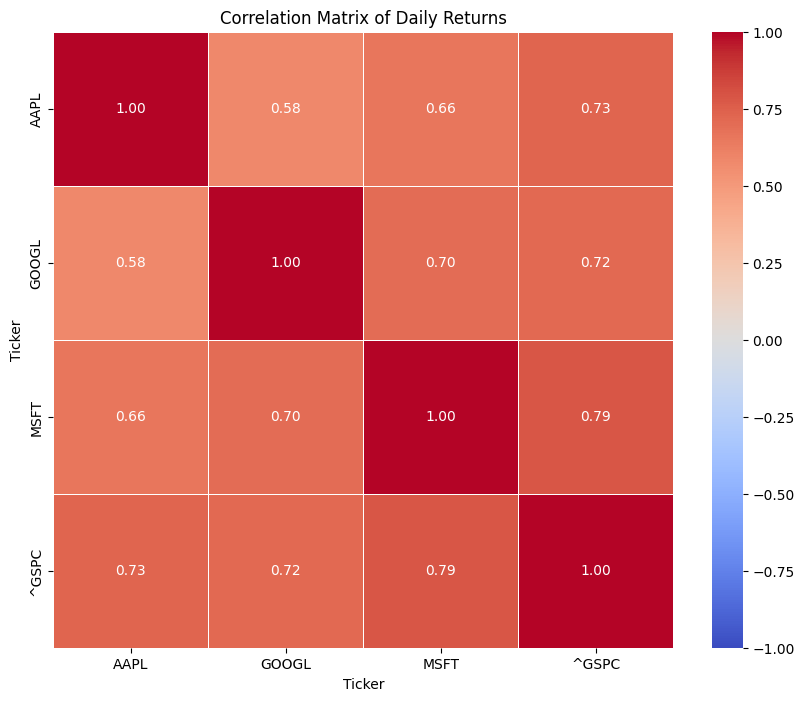

In [17]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Correlation Matrix of Daily Returns ---")
    correlation_matrix = daily_returns.corr()
    print(correlation_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Daily Returns")
    plt.show()

**Observation.** The 3 IT companies (AAPL, GOOGL, MSFT) demonstrated strong correlation in stock prices: 0.58 for AAPL/GOOGL, 0.66 for AAPL/MSFT, and 0.7 for GOOGL/MSFT.

**Observation.** Each company had strong correlation with the S&P 500 index: 0.73 for AAPL, 0.72 for GOOGL, and 0.79 for MSFT.

### 3.3. Beta Analysis

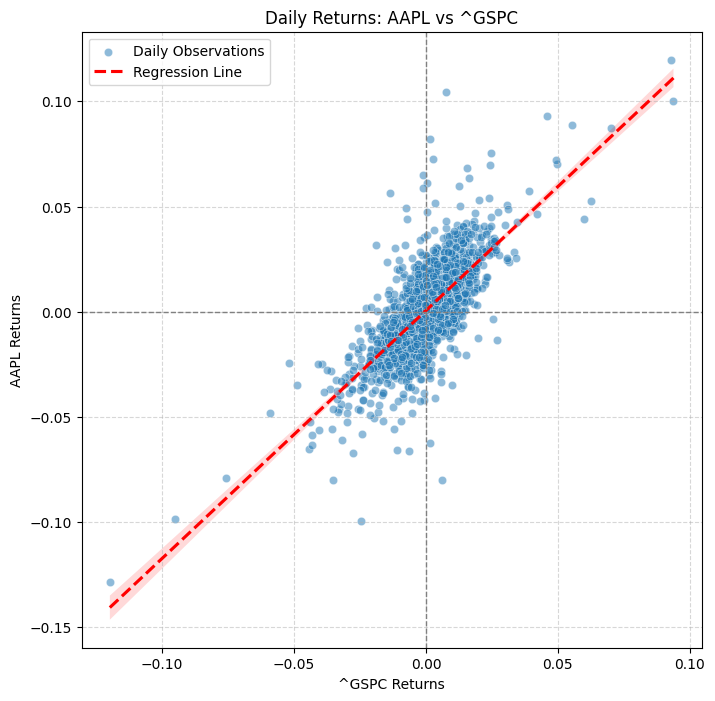

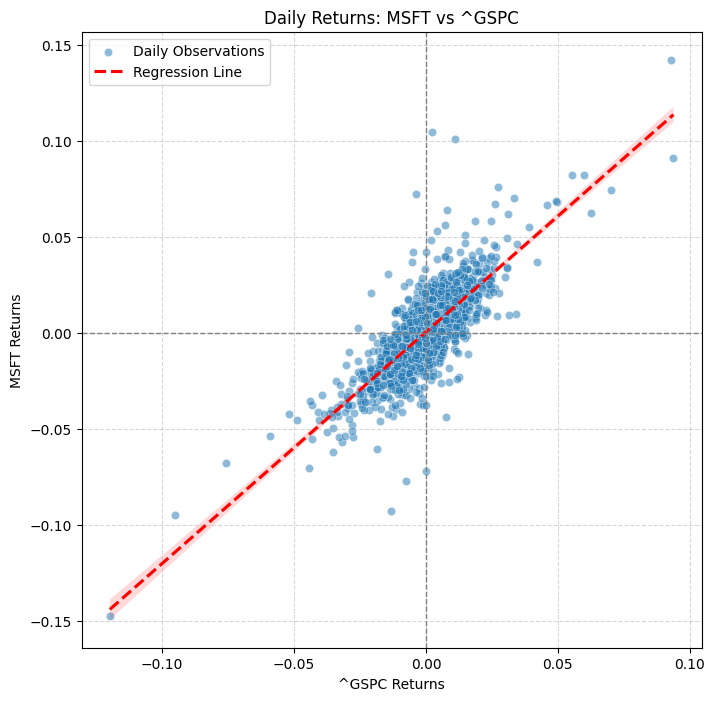

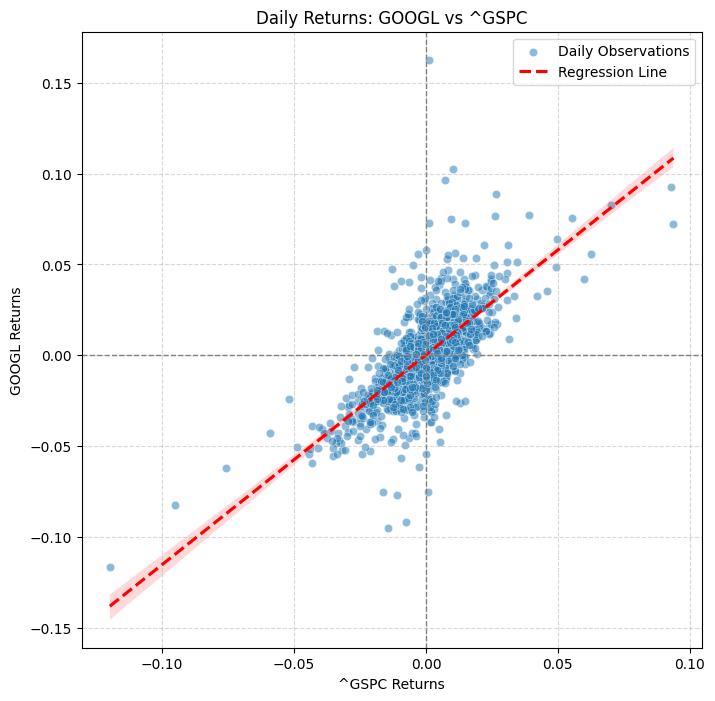

In [48]:
if 'daily_returns' in locals() and not daily_returns.empty and '^GSPC' in daily_returns.columns:
    
    market_ticker = '^GSPC'
    for ticker in tickers_list:
        if ticker != market_ticker and ticker in daily_returns.columns:
            plt.figure(figsize=(8, 8))

            sns.scatterplot(
                x=daily_returns[market_ticker], 
                y=daily_returns[ticker], 
                alpha=0.5, 
                label='Daily Observations'
            ) 
            # Regression line
            sns.regplot(
                x=daily_returns[market_ticker], 
                y=daily_returns[ticker], 
                scatter=False,
                ci = 95, # confidence interval
                color='red',
                line_kws={'linestyle':'--'},
                label='Regression Line'
            )
            plt.title(f"Daily Returns: {ticker} vs {market_ticker}")
            plt.xlabel(f"{market_ticker} Returns")
            plt.ylabel(f"{ticker} Returns")
            plt.axhline(0, color='grey', linestyle='--', lw=1) # Zero line
            plt.axvline(0, color='grey', linestyle='--', lw=1) # Zero line
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()

**Observation.** Each individual asset demonstrated linear correlation with the S&P 500 index.


--- Beta Coefficient Calculation ---
           Beta  Annualized Alpha  R-squared
AAPL   1.178578          0.140009   0.536044
MSFT   1.205153          0.126762   0.621596
GOOGL  1.153464          0.074252   0.513971


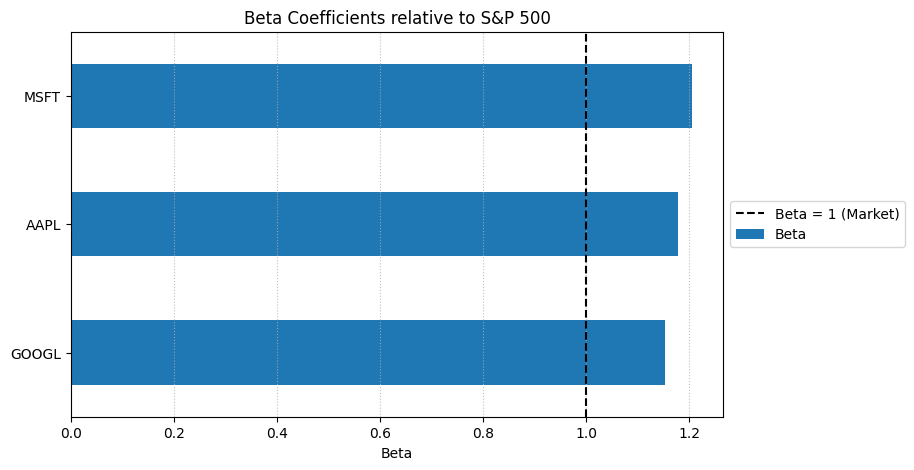

In [19]:
if 'daily_returns' in locals() and not daily_returns.empty and '^GSPC' in daily_returns.columns:
    print("\n--- Beta Coefficient Calculation ---")
    market_ticker = '^GSPC'
    market_returns = daily_returns[market_ticker].dropna()

    beta_values = {}
    alpha_values = {}
    r_squared_values = {}

    for ticker in tickers_list:
        if ticker != market_ticker and ticker in daily_returns.columns:
            asset_returns = daily_returns[ticker].dropna()

            # Make sure date indices are the same
            common_index = market_returns.index.intersection(asset_returns.index)
            X = market_returns.loc[common_index]
            y = asset_returns.loc[common_index]

            if len(X) > 1 and len(y) > 1:
                slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
                beta_values[ticker] = slope
                alpha_values[ticker] = intercept * 252 # Annualized alpha
                r_squared_values[ticker] = r_value**2
            else:
                print(f"Not enough data points for regression for {ticker} after aligning with market.")
                beta_values[ticker] = np.nan
                alpha_values[ticker] = np.nan
                r_squared_values[ticker] = np.nan


    beta_df = pd.DataFrame.from_dict(beta_values, orient='index', columns=['Beta'])
    alpha_df = pd.DataFrame.from_dict(alpha_values, orient='index', columns=['Annualized Alpha'])
    r_squared_df = pd.DataFrame.from_dict(r_squared_values, orient='index', columns=['R-squared'])

    beta_analysis_df = pd.concat([beta_df, alpha_df, r_squared_df], axis=1)
    
    print(beta_analysis_df)

    if not beta_analysis_df.empty:
        beta_to_plot = beta_analysis_df['Beta'].sort_values(ascending=True)

        fig, ax = plt.subplots(figsize=(9, 5))
        
        beta_to_plot.plot(kind='barh', color='tab:blue', label='Beta', ax=ax)
        
        ax.set_title('Beta Coefficients relative to S&P 500')
        ax.set_xlabel('Beta')
        # ax.set_ylabel('Ticker')
        
        ax.axvline(1.0, color='black', linestyle='--', label='Beta = 1 (Market)')
        
        fig.subplots_adjust(right=0.85)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        ax.grid(axis='x', linestyle=':', alpha=0.8)
        plt.show()

**Observation.** Each individual asset demonstrated positive beta coefficient confirming positive correlation with the index. Moreover, each beta is more than 1 (AAPL: 1.18, MSFT: 1.21, GOOGL: 1.15) indicating stronger price movement (volatility) compared to that of the S&P 500 index.

**Observation.** Each individual asset had positive alpha (AAPL: 0.14, MSFT: 0.12, GOOGL: 0.07) highlighting making more profit compared to the index.

**Observation.** Each individual asset's R-squared was approximately 0.5 - 0.6 demonstrating a significant part of the asset's volatility being explained by the index volatility.

## 4. In-depth Analysis of the Market Stress Period (COVID-19, H1 2020)

### 4.1. Data preparation

In [20]:
# High volatility (stress) period
stress_start_date = "2019-12-01"
stress_end_date = "2020-06-30"

if not close_data.empty:
    close_data_stress = close_data.loc[stress_start_date:stress_end_date].copy()
else:
    close_data_stress = pd.DataFrame()

if 'daily_returns' in locals() and not daily_returns.empty:
    daily_returns_stress = daily_returns.loc[stress_start_date:stress_end_date].copy()
else:
    daily_returns_stress = pd.DataFrame()

print(f"--- Analyzing stress period: {stress_start_date} to {stress_end_date} ---")

if close_data_stress.empty or daily_returns_stress.empty:
    print("Not enough data for the specified stress period. Skipping this section.")

--- Analyzing stress period: 2019-12-01 to 2020-06-30 ---


### 4.2. Return and Volatility anlysis during stress period

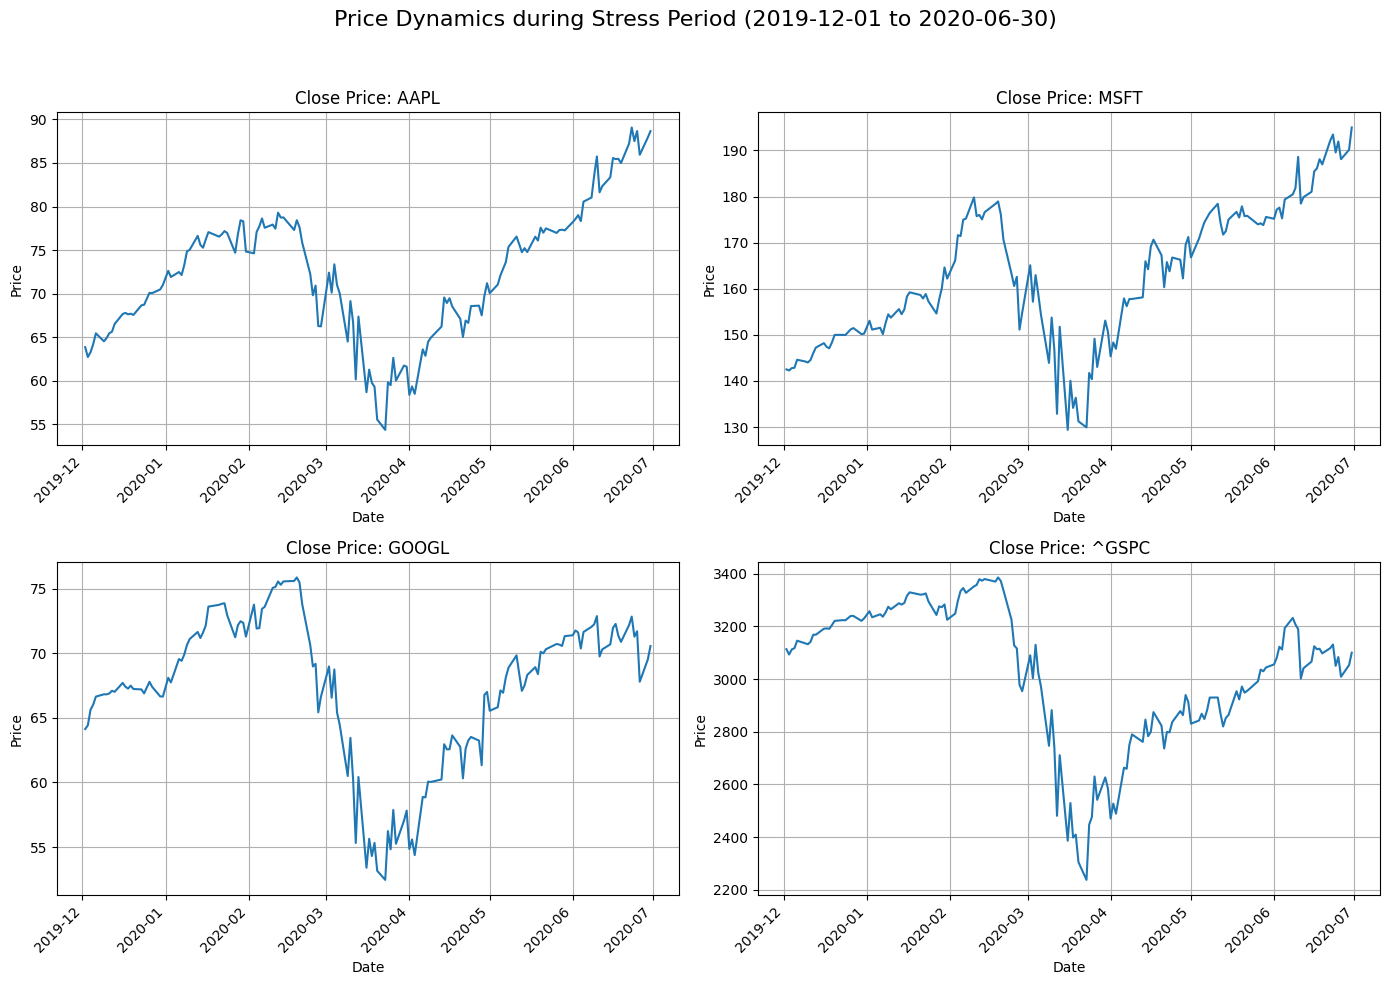

In [21]:
if not close_data_stress.empty and not daily_returns_stress.empty:

    # Make a grid for plots
    num_tickers = len(tickers_list)
    if num_tickers == 4:
        nrows = 2
        ncols = 2
    elif num_tickers <= 2 :
        nrows = 1
        ncols = num_tickers
    elif num_tickers == 3:
        nrows = 1
        ncols = 3
    else:
        nrows = int(np.ceil(np.sqrt(num_tickers)))
        ncols = int(np.ceil(num_tickers / nrows))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10), sharex=False, sharey=False)
    axes_flat = axes.flatten()

    for i, ticker in enumerate(tickers_list):
        if i < len(axes_flat):
            current_ax = axes_flat[i]

            if ticker in close_data_stress.columns:
                close_data_stress[ticker].plot(ax=current_ax, label='Close Price')
                current_ax.set_title(f"Close Price: {ticker}")
                current_ax.set_xlabel("Date")
                current_ax.set_ylabel("Price")
                #current_ax.legend()
                current_ax.grid(True)
                current_ax.tick_params(axis='x', rotation=45)
            else:
                current_ax.set_title(f"{ticker} - No data")
                current_ax.axis('off')
        else:
            break

    # Delete empty axes
    for j in range(num_tickers, nrows * ncols):
        fig.delaxes(axes_flat[j])

    fig.suptitle(f"Price Dynamics during Stress Period ({stress_start_date} to {stress_end_date})", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("Skipping stress period price plots due to missing base data (close_data_stress or daily_returns_stress).")

**Observation.** During considered stress period every asset experienced significant decrease in stocks prices from the middle of February to the middle of March 2020.

**Observation.** By the middle of 2020 AAPL and MSFT overcame the decline and their prices were the highest during the period. The prices of GOOGL and ^GSPC did not reach the maximum value achieved before the decrease.

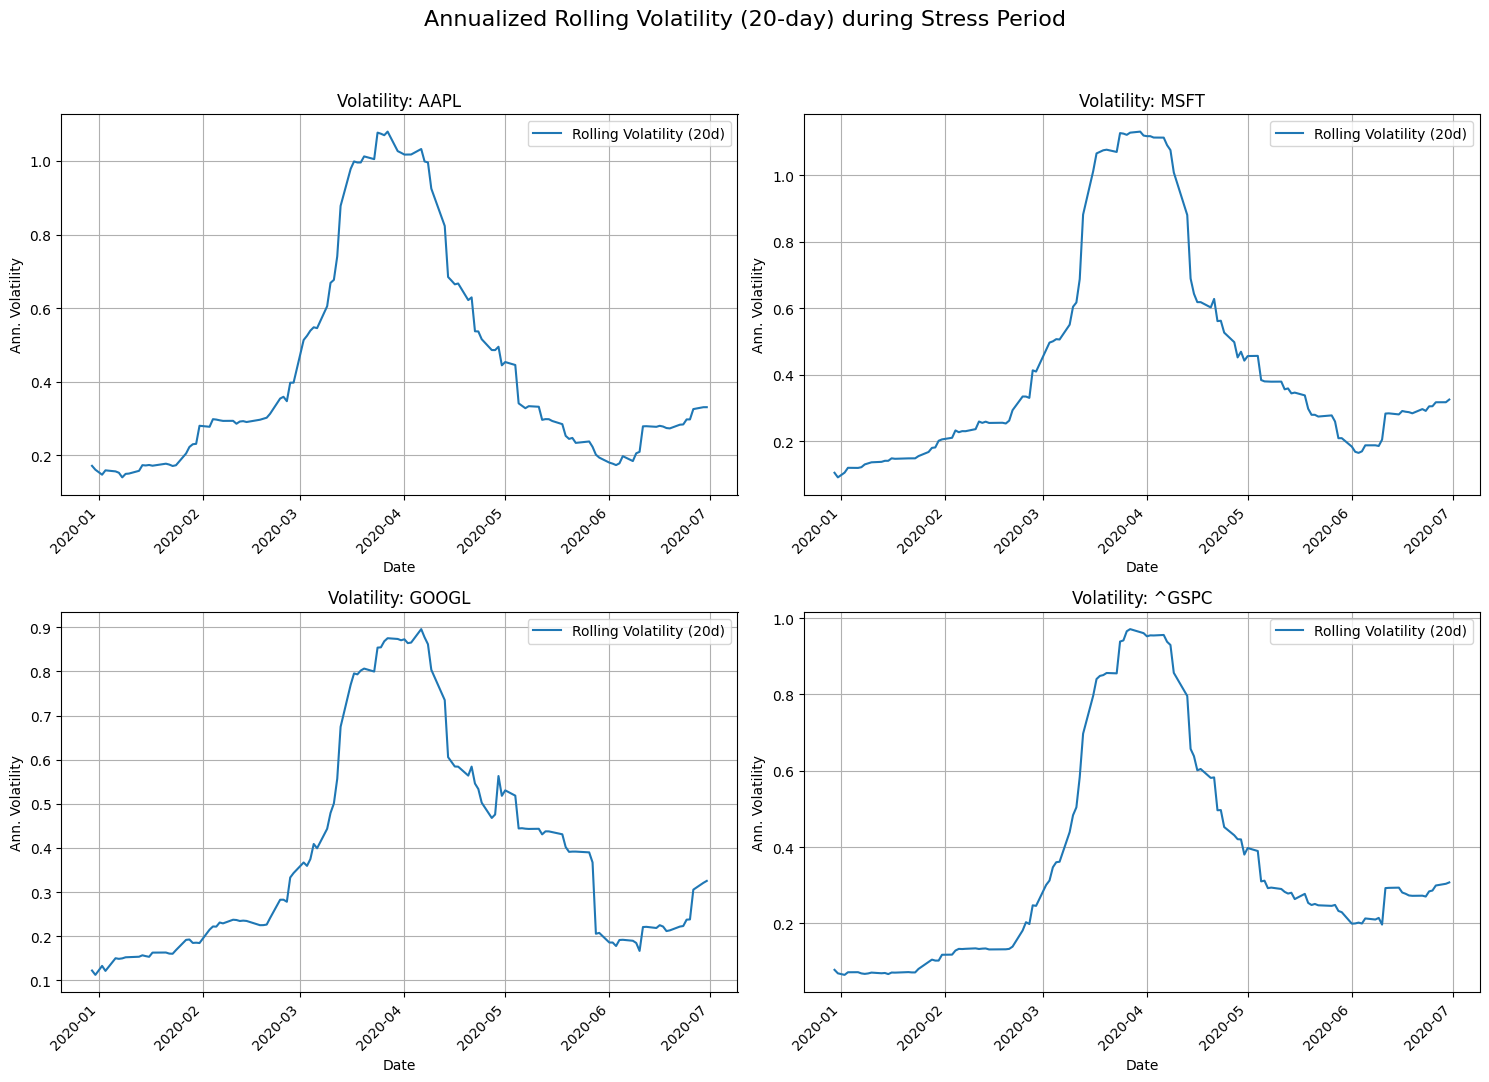

In [22]:
if not daily_returns_stress.empty:
    
    vol_window = 20 
    num_tickers = len(tickers_list)

    # Make a grid for plots
    if num_tickers == 4:
        nrows = 2
        ncols = 2
    elif num_tickers <= 2:
        nrows = 1
        ncols = num_tickers
    elif num_tickers == 3:
        nrows = 1
        ncols = 3
    else:
        nrows = int(np.ceil(np.sqrt(num_tickers)))
        ncols = int(np.ceil(num_tickers / nrows))

    fig_vol, axes_vol = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 11), sharex=False, sharey=False) # Немного другие размеры
    axes_vol_flat = axes_vol.flatten()

    for i, ticker in enumerate(tickers_list):
        if i < len(axes_vol_flat):
            current_ax = axes_vol_flat[i]

            if ticker in daily_returns_stress.columns:
                rolling_std_stress = daily_returns_stress[ticker].rolling(window=vol_window).std() * (252**0.5)

                if not rolling_std_stress.dropna().empty:
                    rolling_std_stress.plot(ax=current_ax, label=f'Rolling Volatility ({vol_window}d)')
                    current_ax.set_title(f"Volatility: {ticker}")
                    current_ax.set_xlabel("Date")
                    current_ax.set_ylabel("Ann. Volatility")
                    current_ax.legend()
                    current_ax.grid(True)
                    current_ax.tick_params(axis='x', rotation=45)
                    current_ax.tick_params(axis='y')
                else:
                    current_ax.set_title(f"{ticker} - Not enough data for volatility")
                    current_ax.axis('off')
            else:
                current_ax.set_title(f"{ticker} - Data not available")
                current_ax.axis('off')
        else:
            break 

    for j in range(num_tickers, nrows * ncols):
        fig_vol.delaxes(axes_vol_flat[j])

    fig_vol.suptitle(f"Annualized Rolling Volatility ({vol_window}-day) during Stress Period", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("Skipping stress period volatility plots due to missing daily_returns_stress data.")

**Observation.** Each asset's volatility increased approximately tenfold during the month between the middle of March and the middle of April 2020.

### 4.3. Analysis of maximum drawdowns during stress period


--- Maximum Drawdowns during stress period (2019-12-01 to 2020-06-30) ---
Maximum Drawdowns (%):
MSFT     28.039267
GOOGL    30.870826
AAPL     31.427280
^GSPC    33.924960
dtype: float64


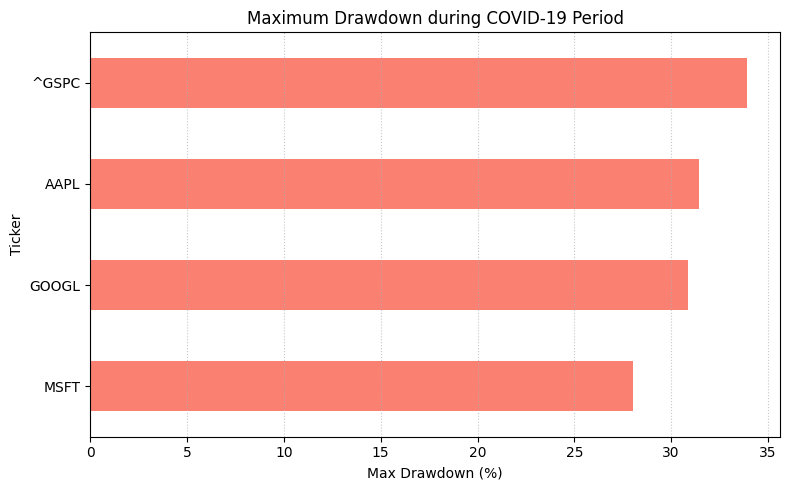

In [24]:
def calculate_max_drawdown(prices_series):
    """
    Calculates the maximum drawdown for a time series of prices
    prices_series: pandas Series of prices.
    """
    if prices_series.empty or len(prices_series) < 2:
        return np.nan

    cumulative_max = prices_series.cummax()
    drawdown = (cumulative_max - prices_series) / cumulative_max
    max_dd = drawdown.max()
    return max_dd

if not close_data_stress.empty:
    print(f"\n--- Maximum Drawdowns during stress period ({stress_start_date} to {stress_end_date}) ---")
    max_drawdowns_stress = {}
    for ticker in tickers_list:
        if ticker in close_data_stress.columns:
            max_drawdowns_stress[ticker] = calculate_max_drawdown(close_data_stress[ticker])
        else:
            max_drawdowns_stress[ticker] = np.nan

    max_drawdowns_stress_df = pd.Series(max_drawdowns_stress).sort_values()

    print("Maximum Drawdowns (%):")
    print(max_drawdowns_stress_df * 100)

    if not max_drawdowns_stress_df.dropna().empty:
        plt.figure(figsize=(8, 5))
        (max_drawdowns_stress_df * 100).plot(kind='barh', color='salmon')
        plt.title(f'Maximum Drawdown during COVID-19 Period')
        plt.xlabel('Max Drawdown (%)')
        plt.ylabel('Ticker')
        plt.grid(axis='x', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    if not close_data.empty:
        print("Skipping stress period drawdown calculation due to missing price data for the period.")

**Observation.** Each asset exhibited strong drawdowns during the stress period: 28.04% for MSFT, 30.87% for GOOGL, 31.43% for AAPL, and 33.92% for the S&P 500 index.

### 4.4. Analysis of correlations during stress period

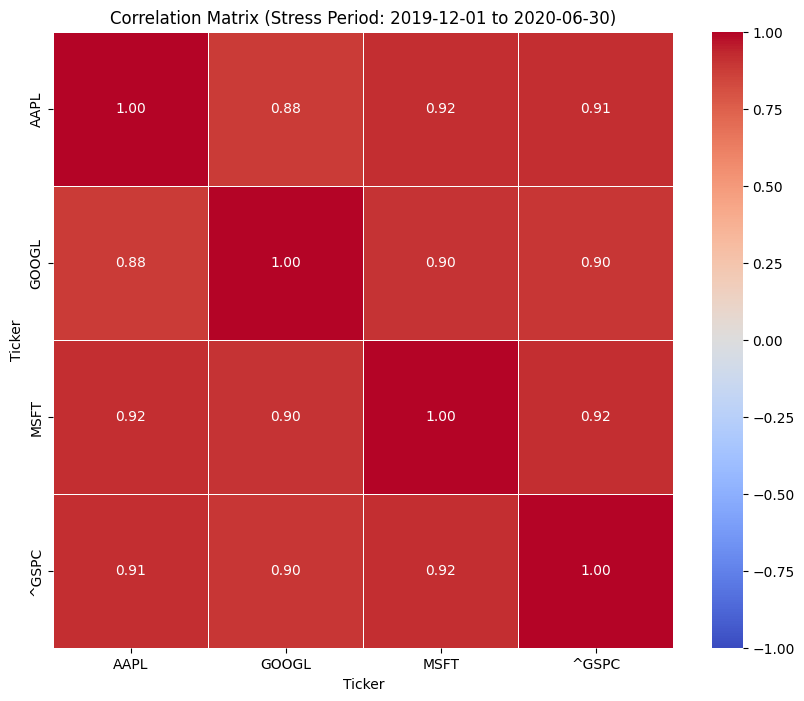

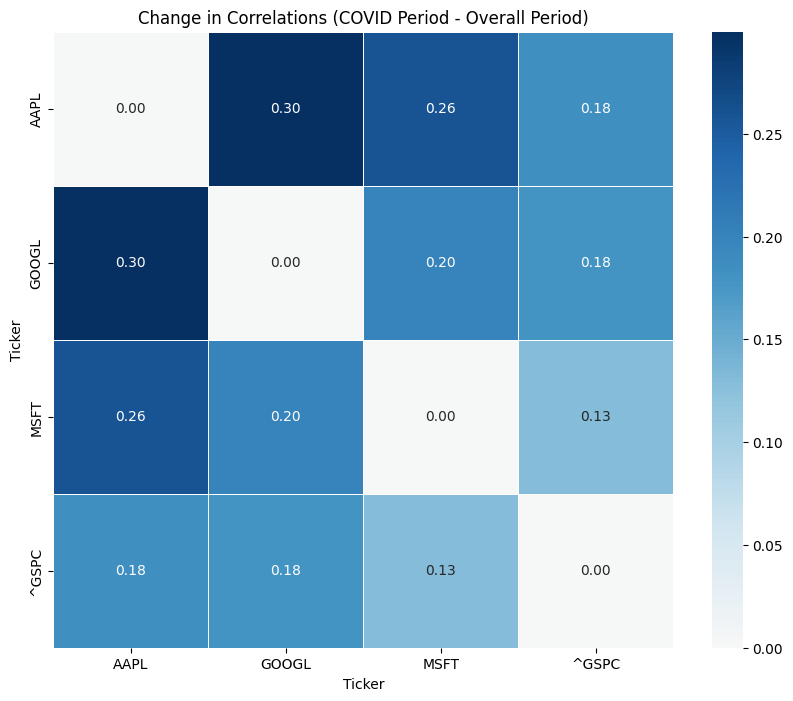

In [47]:
if 'daily_returns' in locals() and not daily_returns.empty:
    if not daily_returns_stress.empty:
        correlation_matrix_stress = daily_returns_stress.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix_stress, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
        plt.title(f"Correlation Matrix (Stress Period: {stress_start_date} to {stress_end_date})")
        plt.show()

        # Overall correlation matrix from subsec. 3.2
        if 'correlation_matrix' in locals():
            correlation_change = correlation_matrix_stress - correlation_matrix
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_change, annot=True, cmap='RdBu', fmt=".2f", linewidths=.5, center=0)
            plt.title(f"Change in Correlations (COVID Period - Overall Period)")
            plt.show()
        else:
            print("Overall correlation matrix ('correlation_matrix') not found for comparison.")
    else:
        print(f"Data for the stress period ('daily_returns_stress') is empty. Skipping correlation analysis for this period.")

else:
    print("Base DataFrame 'daily_returns' is empty or not defined. Skipping all correlation analysis related to it.")

**Observation.** During the stress period correlations between the assets significantly increased:
- to 0.88 for AAPL/GOOGL (+ 0.30),
- to 0.92 for AAPL/MSFT (+ 0.26),
- to 0.90 for GOOGL/MSFT (+ 0.20),
- to 0.91 for AAPL/^GSPC (+ 0.18),
- to 0.90 for GOOGL/^GSPC (+ 0.18),
- to 0.92 for MSFT/^GSPC (+ 0.13).

## 5. Conclusion

In this project I have analyzed the dynamics and statistical properties of stock prices of Apple, Google, Microsoft, and S&P 500 index spanning the period from 2014 to 2024.

**Individual Asset Dynamics.** The statistical properties, price trends, return distributions, and volatility characteristics (including clustering and peak volatility periods) of each asset.

**Observation.** There are notable prices volatilities in the first half of 2020.

**Observation.** Each asset yielded income (mean > 0) during the considered 11-year period.

**Observation.** Each asset's daily volatility is between 1% and 2%.

**Observation.** The highest daily price rise constitued to 16.26% (GOOGL) and the maximum drawdown was 14.74% (MSFT).

**Observation.** GOOGL and MSFT exhibited positive skewness meaning these assets made profits more frequently than losses. The behavior of AAPL and ^GSPC prices is opposite in this sense.

**Observation.** Each asset demontrates large positive kurtosis (> 5) indicating the prices destributions had heavier tails compared to normal distribution. This non-gaussianity of market prices manifested itself drammatically for the index ^GSPC.

**Observation.** Each asset has a lot of points behind whiskers signalling of many days of exceptional daily returns.

**Observation.** Index prices (^GSPC) are less volatile compared to those of individual assets that is indicated by the interquartile ranges.

**Observation.** Each asset exhibited the highest volitility values during March - April 2020.

**Observation.** Each asset demonetrated volatility clustering when periods of high volitility are followed by periods of high volatility, and periods of low volitility are followed by periods of low volatility.

**Observation.** With 95% confidence: AAPL and ^GSPC exhibit 18-day volatility clustering periods. For MSFT the clustring period is 16 days. The clustering period for GOOGL is between 13 and 17 days.

**Observation.** AAPL demonstrated the highest annualized return of 28.35% followed by MSFT with 27.35% of annualized return. The annualized return of GOOGL was 21.47% while for the index the return constitued 12.18%.

**Observation.** The highest annualized volatility was for AAPL stock prices (27.91%) with almost the same value (27.90%) for AAPL. MSFT had slightly lower volatility of 26.50%, and for the index volatility was 17.34%.

**Observation.** Individual assets made significantly higher profits in return of higher risk in terms of greater volatilities.

**Observation.** The 3 IT companies (AAPL, GOOGL, MSFT) demonstrated strong correlation in stock prices: 0.58 for AAPL/GOOGL, 0.66 for AAPL/MSFT, and 0.7 for GOOGL/MSFT.

**Observation.** Each company had strong correlation with the S&P 500 index: 0.73 for AAPL, 0.72 for GOOGL, and 0.79 for MSFT.

**Observation.** Each individual asset demonstrated linear correlation with the S&P 500 index.

**Observation.** Each individual asset demonstrated positive beta coefficient confirming positive correlation with the index. Moreover, each beta is more than 1 (AAPL: 1.18, MSFT: 1.21, GOOGL: 1.15) indicating stronger price movement (volatility) compared to that of the S&P 500 index.

**Observation.** Each individual asset had positive alpha (AAPL: 0.14, MSFT: 0.12, GOOGL: 0.07) highlighting making more profit compared to the index.

**Observation.** Each individual asset's R-squared was approximately 0.5 - 0.6 demonstrating a significant part of the asset's volatility being explained by the index volatility.

**Observation.** During considered stress period every asset experienced significant decrease in stocks prices from the middle of February to the middle of March 2020.

**Observation.** By the middle of 2020 AAPL and MSFT overcame the decline and their prices were the highest during the period. The prices of GOOGL and ^GSPC did not reach the maximum value achieved before the decrease.

**Observation.** Each asset's volatility increased approximately tenfold during the month between the middle of March and the middle of April 2020.

**Observation.** Each asset exhibited strong drawdowns during the stress period: 28.04% for MSFT, 30.87% for GOOGL, 31.43% for AAPL, and 33.92% for the S&P 500 index.

**Observation.** During the stress period correlations between the assets significantly increased:
- to 0.88 for AAPL/GOOGL (+ 0.30),
- to 0.92 for AAPL/MSFT (+ 0.26),
- to 0.90 for GOOGL/MSFT (+ 0.20),
- to 0.91 for AAPL/^GSPC (+ 0.18),
- to 0.90 for GOOGL/^GSPC (+ 0.18),
- to 0.92 for MSFT/^GSPC (+ 0.13).



In this project, I have conducted an exploratory data analysis of the historical price dynamics and statistical properties of three major technology stocks – Apple (AAPL), Microsoft (MSFT), and Alphabet (GOOGL) – alongside the S&P 500 index (^GSPC), spanning the period from January 2014 to December 2024. The analysis aimed to characterize individual asset behaviors, their interrelationships, and their performance during a significant market stress event.

The individual asset analysis revealed that all three technology stocks and the S&P 500 index delivered positive mean daily returns over the eleven-year period, translating into substantial annualized gains. Notably, AAPL and MSFT exhibited the highest annualized returns at 28.35% and 27.35% respectively, followed by GOOGL (21.47%), all outperforming the S&P 500's 12.18%. Daily return distributions for all assets displayed significant positive kurtosis (considerably >5), indicative of leptokurtic ("heavy-tailed") behavior, meaning extreme price movements occurred more frequently than predicted by a normal distribution. This was particularly pronounced for the S&P 500 index. Skewness varied, with GOOGL and MSFT showing positive skewness (suggesting a tendency towards more frequent small gains and occasional large gains), while AAPL and the S&P 500 exhibited negative skewness. Volatility analysis confirmed the phenomenon of volatility clustering across all assets, with estimated clustering periods ranging from approximately 13 to 18 days. Peak daily volatility for all assets was observed during March-April 2020.

Cross-asset relationship analysis highlighted that the selected technology stocks generally offered higher returns at the cost of greater volatility compared to the broader market index. AAPL recorded the highest annualized volatility (27.91%), closely followed by GOOGL (27.90%) and MSFT (26.50%), all exceeding the S&P 500's 17.34%. Strong positive correlations were observed among the three tech companies (ranging from 0.58 to 0.70) and between each company and the S&P 500 index (0.72 to 0.79), indicating a significant degree of co-movement. Beta analysis confirmed this strong market linkage, with all three stocks exhibiting beta coefficients greater than 1 (AAPL: 1.18, MSFT: 1.21, GOOGL: 1.15). This signifies that these tech stocks were, on average, more volatile than the S&P 500 and tended to amplify market movements. Importantly, all three stocks generated positive alpha (AAPL: 14.0%, MSFT: 12.7%, GOOGL: 7.4% annualized), suggesting they delivered returns in excess of what would be predicted by their systematic risk (beta) alone. The R-squared values, ranging from approximately 0.51 to 0.62, indicate that a substantial portion of each stock's volatility can be attributed to overall market movements.

The analysis of the H1 2020 market stress period (COVID-19 pandemic) underscored the heightened risk environment. All analyzed assets experienced a sharp price decline from mid-February to mid-March 2020, accompanied by an approximate tenfold surge in rolling volatility. Maximum drawdowns were significant across the board, with the S&P 500 experiencing the largest at 33.92%, followed by AAPL (31.43%), GOOGL (30.87%), and MSFT (28.04%). Notably, AAPL and MSFT demonstrated strong resilience, recovering from these declines and reaching new highs within the H1 2020 period, whereas GOOGL and the S&P 500 had not fully reclaimed their pre-crisis peaks by mid-2020. A key finding during this stress period was a dramatic increase in correlations between all assets, with pair-wise correlations among the tech stocks and with the S&P 500 surging to levels between 0.88 and 0.92. This highlights the common market adage that "correlations go to one" during crises, reducing diversification benefits when they are most needed.

In summary, this exploratory analysis provides valuable insights into the behavior of leading technology stocks and the broader market. While offering superior historical returns, these tech assets also carried higher volatility and a stronger sensitivity to market movements than the S&P 500. Their positive alpha generation is a key indicator of past outperformance. The COVID-19 stress period emphasized their susceptibility to systemic shocks and the significant, albeit temporary, increase in market-wide correlations during crises. These findings underscore the importance of considering both individual asset characteristics and broader market dynamics in investment decision-making and risk management.